In [1]:
import numpy as np
import scipy
import scipy.integrate as spi
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx
import torch
import scipy.optimize as spo

/cis/home/yma93/miniconda3/envs/ml/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def solve_equation(f, range, tol=1e-5):
    """
    Find the root of the function f in the interval [a, b] using binary search.
    """
    a, b = range
    while abs(a - b) > tol:
        midpoint = (a + b) / 2.0
        f_a, f_midpoint = f(a), f(midpoint)
        if abs(f_midpoint) < tol:
            return midpoint
        if f_a * f_midpoint < 0:
            b = midpoint
        else:
            a = midpoint
    return (a + b) / 2.0


def gaussian_integral(f):
    """General calculation of E[f(x,y)] for x,y iid N(0, 1)."""
    return spi.dblquad(
        lambda x, y: f(x, y) * np.exp(-(x**2) / 2.0) * np.exp(-(y**2) / 2.0) / (2.0 * np.pi),
        -np.inf,
        np.inf,
        lambda x: -np.inf,
        lambda x: np.inf,
    )[0]


def H(z, sigma, c):
    """Subordination function."""
    return z + gaussian_integral(
        lambda x, y: 1 / (z - sigma(c * np.sqrt(2 / np.pi) * np.abs(x) + y))
    )


def H_prime(z, sigma, c, sigma_image):
    """Subordination function derivative."""
    if (
        z >= sigma_image[0] and z <= sigma_image[1]
    ):  # H_prime undefined when z is in the range of the support of nu
        return -np.inf
    return 1.0 - gaussian_integral(
        lambda x, y: 1 / (z - sigma(c * np.sqrt(2 / np.pi) * np.abs(x) + y)) ** 2
    )


def theta(c, sigma, sigma_image):
    """Compute the effective signal."""

    def f(lam):  # lam_max is the root of this function, note it decreases in lam
        return (
            gaussian_integral(
                lambda g, d: g**2 / (lam - sigma(c * np.sqrt(2 / np.pi) * np.abs(g) + d))
            )
            - 1.0 / c
        )

    a = sigma_image[1] + 1e-7  # lower bound for lam_max
    b = c + max(abs(sigma_image[0]), abs(sigma_image[1]))  # upper bound for lam_max
    # print(c,a,b, f(a), f(b))
    if not (
        f(a) > 0 and f(b) < 0
    ):  # no outlier eigenvalue (all eigenvalues are inside the image of sigma)
        return sigma_image[
            1
        ]  # return something inside the image of sigma, so that H'(theta) is undefined

    # xs = np.linspace(a, b, 100)
    # f_values = np.array([f(lam) for lam in xs])
    # plt.plot(xs, f_values)
    # plt.show()
    # i = np.where(f_values > 0)[0][-1]
    lam_max = solve_equation(f, [a, b])  # find the root by binary search
    return lam_max


def c_critical(c_range, sigma, sigma_image, plot=True):
    """Critical value of c."""
    if plot:  # plot the diagram for theta(c) and H_prime(theta(c)) values
        c_values = np.linspace(c_range[0], c_range[1], 100)
        theta_values = np.array([theta(c, sigma, sigma_image) for c in c_values])
        H_prime_values = np.array(
            [
                H_prime(theta_values[i], sigma, c_values[i], sigma_image)
                for i in range(len(c_values))
            ]
        )
        # i = np.where(H_prime_values > -1)[0][0] # only plot the part where H_prime > -1
        i = 0
        fig, axes = plt.subplots(2, 1, sharex=True)
        axes[0].plot(c_values[i:], theta_values[i:])
        axes[1].plot(c_values[i:], H_prime_values[i:])
        axes[0].set_xlabel("$c$")
        axes[0].set_ylabel("$\\theta(c)$ (effective signal)")
        axes[1].set_xlabel("$c$")
        axes[1].set_ylabel("$H^{\\prime}(\\theta(c))$")
        plt.show()

    if (
        H_prime(theta(c_range[0], sigma, sigma_image), sigma, c_range[0], sigma_image)
        * H_prime(theta(c_range[1], sigma, sigma_image), sigma, c_range[1], sigma_image)
        > 0
    ):  # no solution for H'=0 in the range
        return c_range[1]
    c_critical = solve_equation(
        lambda c: H_prime(theta(c, sigma, sigma_image), sigma, c, sigma_image), c_range
    )
    return c_critical


def outlier_eval(c, sigma, sigma_image):
    """Evaluate the outlier eigenvalue when c > c_critical."""
    return H(theta(c, sigma, sigma_image), sigma, c)

# Validation of the method on simple $\sigma = \tanh$ 

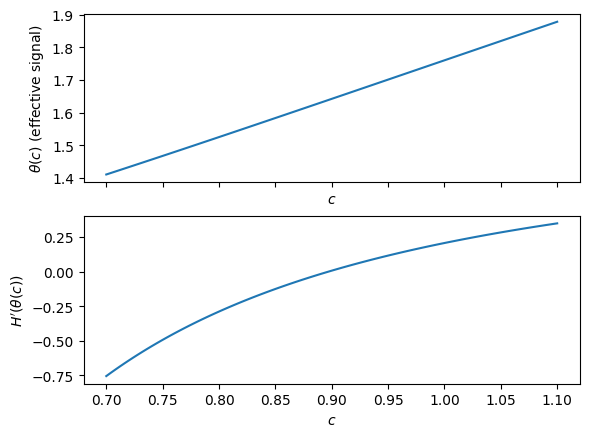

0.8973632812500001

In [3]:
sigma = lambda x: np.tanh(x)
c_critical(c_range=[0.7, 1.1], sigma=sigma, sigma_image=[-1, 1], plot=True)

In [4]:
outlier_eval(c=1, sigma=sigma, sigma_image=[-1, 1])

2.594198938330409

In [3]:
def custom_laplacian_lam_max(A, sigma):
    """Given adjacency matrix A, compute lambda_max(L) where L = \hat{A} + diag(sigma(\hat{d}))"""
    D = sigma(A.sum(axis=1))
    evals = np.linalg.eigvalsh(A + np.diag(D))
    # plt.hist(evals, bins=500)
    # plt.show()
    return evals.max()


def find_lam_max(sigma, n_range=np.arange(2000, 2500, 500), c=1, num_trials=1):
    null = {}
    planted = {}
    for n in tqdm(n_range):
        k = int(c * np.sqrt(n))
        null_n = []
        planted_n = []
        for trials in tqdm(range(num_trials)):
            W = np.random.normal(0, 1, (n, n))
            W = np.tril(W, -1) + np.tril(W, -1).T
            W /= np.sqrt(n)
            x = np.random.normal(0, 1, n)
            x /= np.linalg.norm(x)
            x = np.abs(x)
            A = c * np.outer(x, x) + W

            X = A + np.diag(sigma(A.sum(axis=1))) - W
            evals = np.linalg.eigvalsh(X)
            # plt.hist(evals, bins=100)
            # plt.show()
            null_n.append(custom_laplacian_lam_max(W, sigma))
            planted_n.append(custom_laplacian_lam_max(A, sigma))
        null[n] = null_n
        planted[n] = planted_n
    return null, planted

In [154]:
null, planted = find_lam_max(sigma, c=1)
print(sum(null[2000]) / len(null[2000]))
print(sum(planted[2000]) / len(planted[2000]))

100%|██████████| 1/1 [00:01<00:00,  1.00s/it]

2.3171853298216876
2.7121947462993274


In [2]:
import numpy as np

c = 5
pre_transformed_dict = {}
transformed_dict = {}
n_ranges = np.arange(4000, 10000, 500)
num_trials = 50
for n in n_ranges:
    upper_triangle_indices = np.triu_indices(n, k=1)
    eval1 = []
    eval2 = []
    for _ in range(num_trials):
        off_diag = np.random.randn((n * (n - 1) // 2))
        on_diag = np.random.randn(n) * 2
        A = np.zeros((n, n))
        A[upper_triangle_indices] = off_diag
        A += A.T
        np.fill_diagonal(A, on_diag)

        subset_size = int(c * np.sqrt(n))
        subset = np.random.choice(range(n), subset_size, replace=False)
        A[np.ix_(subset, subset)] += 1
        A /= np.sqrt(n)
        d = A @ np.ones(n)
        L = A + np.diag(np.tanh(d))
        evals = np.linalg.eigvalsh(L)
        P = np.eye(n) - np.ones((n, n)) / n
        transformed_L = P @ L @ P
        transformed_evals = np.linalg.eigvalsh(transformed_L)
        eval1.append(np.max(evals))
        eval2.append(np.max(transformed_evals))
    pre_transformed_dict[n] = np.array(eval1)
    transformed_dict[n] = np.array(eval2)

In [3]:
def layer_plot(
    ax,
    xs,
    yss,
    max_points=None,
    label=None,
    only_means=False,
    errorbars=False,
    color=None,
    sigma=1.0,
    fill_alpha=0.3,
    linestyle="-",
    linewidth=1,
    elinewidth=1,
):
    means = np.array([np.mean(ys) for ys in yss])
    devs = np.array([np.std(ys) * sigma for ys in yss])
    print(means)
    if max_points is not None:
        n = xs.shape[0]
        thin = max(1, n // max_points)
        xs = xs[::thin]
        means = means[::thin]
        devs = devs[::thin]
    if errorbars:
        ax.scatter(xs, means, c=color, label=label)
        ax.errorbar(
            xs,
            means,
            yerr=devs,
            linestyle=linestyle,
            linewidth=linewidth,
            elinewidth=elinewidth,
            c=color,
        )
    else:
        ax.plot(xs, means, c=color, label=label, linestyle=linestyle, linewidth=linewidth)
        if not only_means:
            ax.fill_between(xs, means, means + devs, alpha=fill_alpha, color=color)
            ax.fill_between(xs, means, means - devs, alpha=fill_alpha, color=color)

In [8]:
transformed_mean = [np.mean(transformed_dict[n]) for n in n_ranges]
transformed_mean[0]

5.715662822584567

[5.71566282 5.73555956 5.76076883 5.77537761 5.79643016 5.80961907
 5.82726545 5.83489951 5.84540801 5.85012409 5.86341049 5.86787047]
[6.16941419 6.16327043 6.16583172 6.16049162 6.166466   6.16499375
 6.16938871 6.16661126 6.16616878 6.16151857 6.16538965 6.16240533]


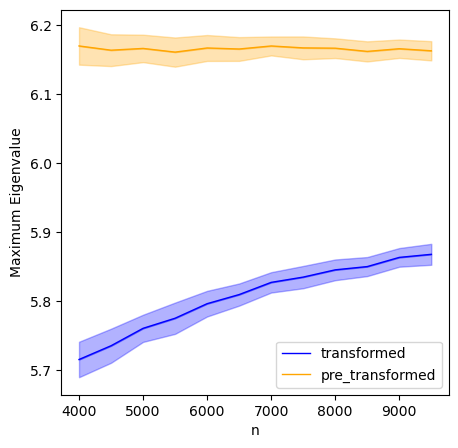

In [11]:
import matplotlib.pyplot as plt

transformed = [transformed_dict[n] for n in n_ranges]
pre_transformed = [pre_transformed_dict[n] for n in n_ranges]
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
layer_plot(ax, n_ranges, transformed, label="transformed", errorbars=False, color="blue")
layer_plot(ax, n_ranges, pre_transformed, label="pre_transformed", errorbars=False, color="orange")
transformed_mean = [np.mean(transformed_dict[n]) for n in n_ranges]
# x0 = transformed_mean[0]
# y = x0 * n_ranges[0] ** (-1/4) * n_ranges ** (1/4)
ax.set_xlabel("n")
ax.set_ylabel("Maximum Eigenvalue")
ax.legend()
# plt.xscale('log')
# plt.yscale('log')
plt.show()

# Find Optimal $\sigma$ with blackbox optimization

In [ ]:
# from scipy.stats import norm


# def compute_cdfs(x, y):
#     """Compute the cdf of sigma(c\sqrt{2/pi} |g| + h)"""


# def discrete_stieltjes(x, y):
#     """General calculation of E[f(x)] for x\sim sigma(c\sqrt{2/pi} |g| + h), where g,h\sim N(0,1)."""
#     """input: x, y are np arrays define a step function f(x) = y[i] for x in (x[i], x[i+1])"""
#     assert x[0] == -np.inf
#     assert x[-1] == np.inf
#     F_x = compute_cdfs(x, y)

#     F_x_diff = F_x[1:] - F_x[:-1]
#     return (F_x_diff * y).sum()


# def H_discrete(z, sigma, c):
#     """Subordination function."""
#     sigma_x, sigma_y = sigma
#     return z + discrete_stieltjes(sigma_x, 1.0 / (z - sigma_y))


# def H_prime_discrete(z, sigma, c, sigma_image):
#     """Subordination function derivative."""
#     if (
#         z >= sigma_image[0] and z <= sigma_image[1]
#     ):  # H_prime undefined when z is in the range of the support of nu
#         return -np.inf
#     sigma_x, sigma_y = sigma
#     return 1.0 - discrete_stieltjes(sigma_x, 1.0 / (z - sigma_y) ** 2)


# def c_critical_discrete(c_range, sigma, sigma_image, plot=True):
#     """Critical value of c."""
#     if plot:  # plot the diagram for theta(c) and H_prime(theta(c)) values
#         c_values = np.linspace(c_range[0], c_range[1], 100)
#         theta_values = np.array([theta(c, sigma, sigma_image) for c in c_values])
#         H_prime_values = np.array(
#             [
#                 H_prime_discrete(theta_values[i], sigma, c_values[i], sigma_image)
#                 for i in range(len(c_values))
#             ]
#         )
#         # i = np.where(H_prime_values > -1)[0][0] # only plot the part where H_prime > -1
#         i = 0
#         fig, axes = plt.subplots(2, 1, sharex=True)
#         axes[0].plot(c_values[i:], theta_values[i:])
#         axes[1].plot(c_values[i:], H_prime_values[i:])
#         axes[0].set_xlabel("$c$")
#         axes[0].set_ylabel("$\\theta(c)$ (effective signal)")
#         axes[1].set_xlabel("$c$")
#         axes[1].set_ylabel("$H^{\\prime}(\\theta(c))$")
#         plt.show()

#     if (
#         H_prime(theta(c_range[0], sigma, sigma_image), sigma, c_range[0], sigma_image)
#         * H_prime(theta(c_range[1], sigma, sigma_image), sigma, c_range[1], sigma_image)
#         > 0
#     ):  # no solution for H'=0 in the range
#         return c_range[1]
#     c_critical = solve_equation(
#         lambda c: H_prime_discrete(theta(c, sigma, sigma_image), sigma, c, sigma_image), c_range
#     )
#     return c_critical


# def outlier_eval(c, sigma, sigma_image):
#     """Evaluate the outlier eigenvalue when c > c_critical."""
#     return H(theta(c, sigma, sigma_image), sigma, c)

In [ ]:
# def c_for_step_function(beta, plot=False):
#     """
#     Given parameter for the parametrized sigma function, compute c_critical.
#     beta = (a[0], a[1], ..., a[n], b[0], ..., b[n])
#     Define sigma to be a step function parametrized by:
#     f(x) = y[i] for x in (x[i], x[i+1]) where
#     x = (-np.inf, a[0], a[0:1].sum(), ..., a[0:n].sum(), np.inf)
#     y = (0, b[0], b[0:1].sum(), ..., b[0:n].sum(), b[0:n].sum())
#     """
#     if isinstance(beta, list):
#         beta = np.array(beta)
#     n = len(beta) // 2 - 1
#     a, b = beta[0 : n + 1], beta[n + 1 :]
#     assert (a[1:] >= 0).all()
#     assert (b >= 0).all()
#     x = np.cumsum(a)
#     x = np.concatenate(([-np.inf], x, [np.inf]))
#     y = np.cumsum(b)
#     y = np.concatenate(([0], y))

#     image = [0, b.sum()]
#     c = c_critical_discrete([0.3, 0.9], sigma=(x, y), sigma_image=image, plot=plot)
#     return c


# def plot_step_function(beta, ax):
#     n = len(beta) // 2 - 1
#     a, b = beta[0 : n + 1], beta[n + 1 :]
#     x = np.cumsum(a)
#     x = np.concatenate(([-np.inf], x, [np.inf]))
#     y = np.cumsum(b)
#     y = np.concatenate(([0], y))
#     x_s = np.linspace(-10, 10, 1000)
#     y_s = np.zeros_like(x_s)
#     for i in range(0, n + 2):
#         y_s[x_s >= x[i]] = y[i]
#     ax.plot(x_s, y_s)

In [4]:
def c_for_parametrized_tanh(beta):
    """Given parameter for the parametrized sigma function, compute c_critical."""
    sigma = lambda x: beta[0] * np.tanh(beta[1] * x)
    sigma_image = [-beta[0], beta[0]]
    c = c_critical([0.3, 0.9], sigma=sigma, sigma_image=sigma_image, plot=False)
    print(f"beta={beta}, c_critical={c}")
    return c

In [5]:
res = spo.minimize(c_for_parametrized_tanh, [1.0, 1.0], method="Nelder-Mead")
print(res.x)

beta=[1. 1.], c_critical=0.8973632812500001
beta=[1.05 1.  ], c_critical=0.89630126953125
beta=[1.   1.05], c_critical=0.8986679077148438
beta=[1.05 0.95], c_critical=0.8949325561523438
beta=[1.075 0.9  ], c_critical=0.893023681640625
beta=[1.125 0.9  ], c_critical=0.892071533203125
beta=[1.1875 0.85  ], c_critical=0.8895538330078124
beta=[1.2125 0.75  ], c_critical=0.8861846923828125
beta=[1.29375 0.625  ], c_critical=0.8815246582031251
beta=[1.40625 0.575  ], c_critical=0.8791076660156252
beta=[1.571875 0.4125  ], c_critical=0.8766128540039064
beta=[1.678125 0.1875  ], c_critical=0.9
beta=[1.31015625 0.684375  ], c_critical=0.8829299926757812
beta=[1.55546875 0.353125  ], c_critical=0.8771026611328127
beta=[1.83359375 0.140625  ], c_critical=0.9
beta=[1.42871094 0.50390625], c_critical=0.8775650024414063
beta=[1.69863281 0.26171875], c_critical=0.9
beta=[1.49619141 0.44335937], c_critical=0.8765991210937502
beta=[1.51259766 0.50273437], c_critical=0.8772033691406251
beta=[1.54475098 

In [ ]:
from scipy.interpolate import CubicSpline


def c_for_cubic_spline(beta):
    """
    Given parameter for the parametrized sigma function, compute c_critical.
    The parametrization is as follows:
    Define sigma to be cubic spline interpolation of the knots inside [0, beta[0]]; constant outside of it with value at the left/right end point.
    The n knots x1, ..., x_n are evenly spaced between [0, beta[0]].
    y_1 = beta[1], y_2 = beta[1]+beta[2], ..., y_n = beta[1] + ... + beta[n] are the values at the knots.
    """
    n = 5
    assert beta[1] > 0
    assert len(beta) == n + 1
    assert (beta[2:] >= 0).all()

    def spline_extrapolate(t):  # extrapolate the spline outside of [a, b] with constant values
        a, b = beta[0], beta[1]
        x = np.linspace(a, b, n)  # knots
        y = np.cumsum(beta[2:])  # values at knots
        y = np.concatenate([[0], y])
        spline = CubicSpline(x, y, bc_type="clamped", extrapolate=False)

        if isinstance(t, (int, float)):
            if t < a:
                return y[0]
            if t > b:
                return y[-1]
            return spline(t)
        elif isinstance(t, torch.Tensor):
            y = torch.tensor(spline(t))
            y[t < a] = spline(a).item()
            y[t > b] = spline(b).item()
            return y

    x = torch.linspace(-10, 10, 100)
    y = spline_extrapolate(x)
    plt.plot(x, y)
    plt.show()
    image = [0, np.sum(beta[2:])]
    c = c_critical([0.3, 0.9], sigma=spline_extrapolate, sigma_image=image, plot=False)
    print(f"beta={beta}, c_critical={c}")
    return c

In [ ]:
n = 5
x = np.linspace(-5, 5, n)
y = 1.7 * np.tanh(0.58 * x) + 1.7
y[0], y[-1] = 0, 3.4
delta = y[1:] - y[:-1]
beta0 = np.concatenate(([-5, 5], delta))
spo.minimize(c_for_cubic_spline, beta0, method="Nelder-Mead", bounds=bounds)